In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install utilsforecast
from utilsforecast.evaluation import evaluate
from utilsforecast.plotting import plot_series
from utilsforecast.losses import *
import warnings
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 1.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive/')
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Adidas US Sales Datasets.xlsx",header=4,parse_dates=['Invoice Date'])
df = df.drop(df.columns[0], axis=1)
df.info()

Mounted at /content/drive/
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9648 entries, 0 to 9647
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Retailer          9648 non-null   object        
 1   Retailer ID       9648 non-null   int64         
 2   Invoice Date      9648 non-null   datetime64[ns]
 3   Region            9648 non-null   object        
 4   State             9648 non-null   object        
 5   City              9648 non-null   object        
 6   Product           9648 non-null   object        
 7   Price per Unit    9648 non-null   float64       
 8   Units Sold        9648 non-null   int64         
 9   Total Sales       9648 non-null   float64       
 10  Operating Profit  9648 non-null   float64       
 11  Operating Margin  9648 non-null   float64       
 12  Sales Method      9648 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(2), object(

In [ ]:
start_date = df['Invoice Date'].min()
end_date = df['Invoice Date'].max()

print(f"Date range: {start_date} to {end_date}")
print("No of Duplicated rows: "+ str(df.duplicated().sum()))

all_dates = pd.date_range(start=df['Invoice Date'].min(), end=df['Invoice Date'].max())
missing_dates = all_dates.difference(df['Invoice Date'])
missing_dates

Date range: 2020-01-01 00:00:00 to 2021-12-31 00:00:00
No of Duplicated rows: 0


DatetimeIndex(['2020-02-29', '2020-10-11', '2020-10-12', '2020-10-13',
               '2020-10-14', '2020-10-15', '2020-10-16'],
              dtype='datetime64[ns]', freq=None)

In [ ]:
df_forecast = df[['Invoice Date', 'Product', 'Units Sold']].copy()
df_forecast.head(10)

,Invoice Date,Product,Units Sold
0,2020-01-01,Men's Street Footwear,1200
1,2020-01-02,Men's Athletic Footwear,1000
2,2020-01-03,Women's Street Footwear,1000
3,2020-01-04,Women's Athletic Footwear,850
4,2020-01-05,Men's Apparel,900
5,2020-01-06,Women's Apparel,1000
6,2020-01-07,Men's Street Footwear,1250
7,2020-01-08,Men's Athletic Footwear,900
8,2020-01-21,Women's Street Footwear,950
9,2020-01-22,Women's Athletic Footwear,825


In [ ]:

df_forecast.set_index('Invoice Date', inplace=True)

weekly_product_sales = df_forecast.groupby('Product')['Units Sold'].resample('W').sum().reset_index()
weekly_product_sales.head()


,Product,Invoice Date,Units Sold
0,Men's Apparel,2020-01-05,1440
1,Men's Apparel,2020-01-12,722
2,Men's Apparel,2020-01-19,282
3,Men's Apparel,2020-01-26,1763
4,Men's Apparel,2020-02-02,1695


In [ ]:
weekly_product_sales.groupby('Product').size()

,0
Product,
Men's Apparel,105
Men's Athletic Footwear,105
Men's Street Footwear,105
Women's Apparel,104
Women's Athletic Footwear,105
Women's Street Footwear,105


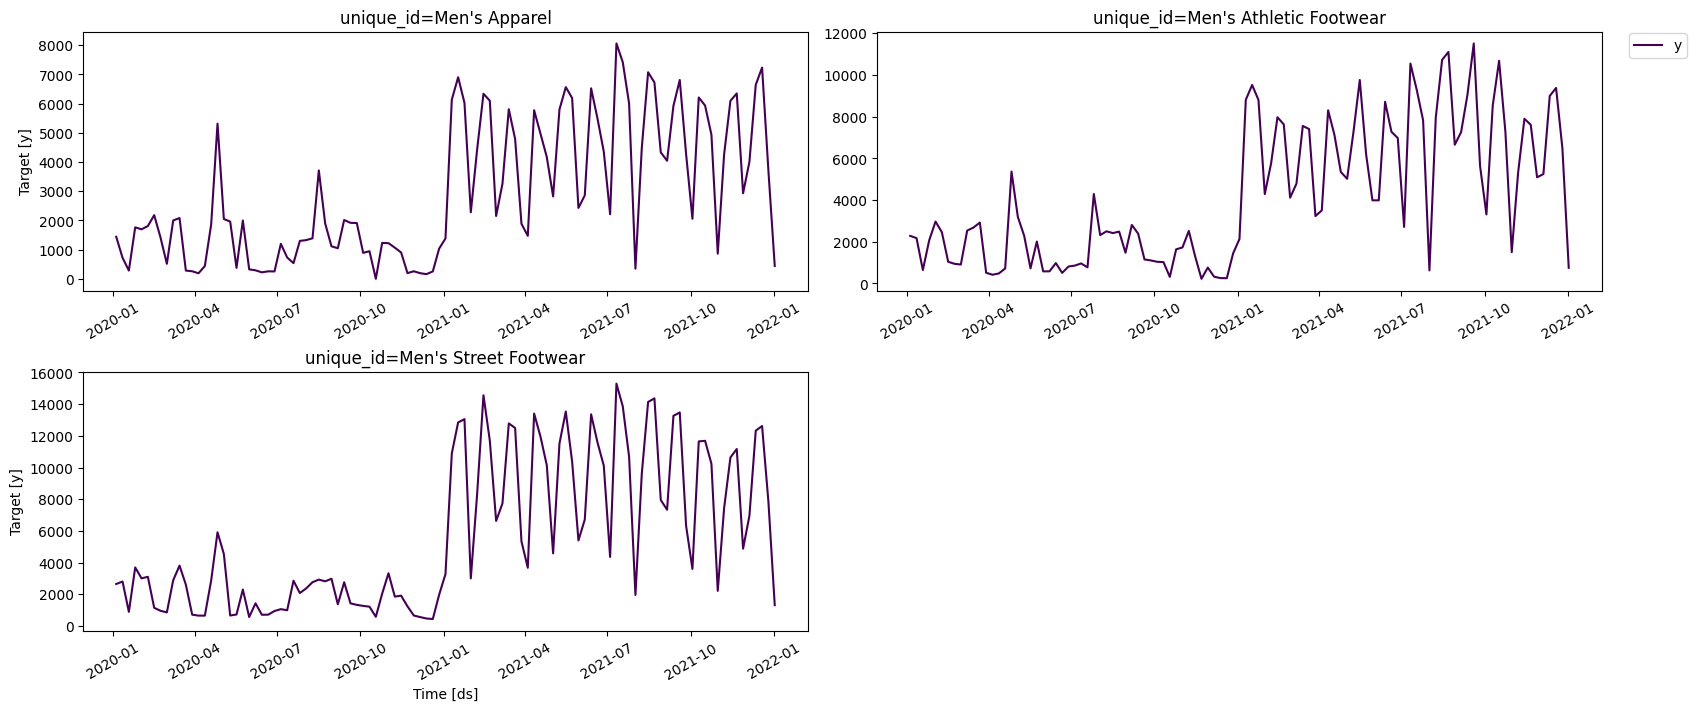

In [ ]:
mens_products = ["Men's Apparel", "Men's Athletic Footwear", "Men's Street Footwear"]
mens_sales = weekly_product_sales[weekly_product_sales['Product'].isin(mens_products)]


# Rename columns to match utilsforecast convention
mens_sales = mens_sales.rename(columns={
    'Product': 'unique_id',
    'Invoice Date': 'ds',
    'Units Sold': 'y'
})

# Plot
plot_series(
    mens_sales,
   # max_insample_length= 30,
    palette="viridis"
)


In [ ]:
# Let's say we want to keep the last 10 weeks per product as test data
test = mens_sales.groupby('unique_id').tail(10).copy()

# Remove those rows from the main (training) dataframe
train = mens_sales.drop(test.index)

# Check the sizes
print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (285, 3)
Test shape: (30, 3)


In [ ]:
!pip install statsforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.8/344.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 8.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2


In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, WindowAverage, HistoricAverage

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x794939fb4360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/ctypes/__init__.py", line 379, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: /usr/local/lib/python3.12/dist-packages/scipy.libs/libscipy_openblas-b75cc656.

In [ ]:
models = [
    Naive(),
    HistoricAverage(),
    WindowAverage(window_size=5),
    SeasonalNaive(season_length=5)
]
horizon = 10

sf = StatsForecast(
    models=models,
    freq='W'
)
sf.fit(df=train)
predicts = sf.predict(h=horizon)


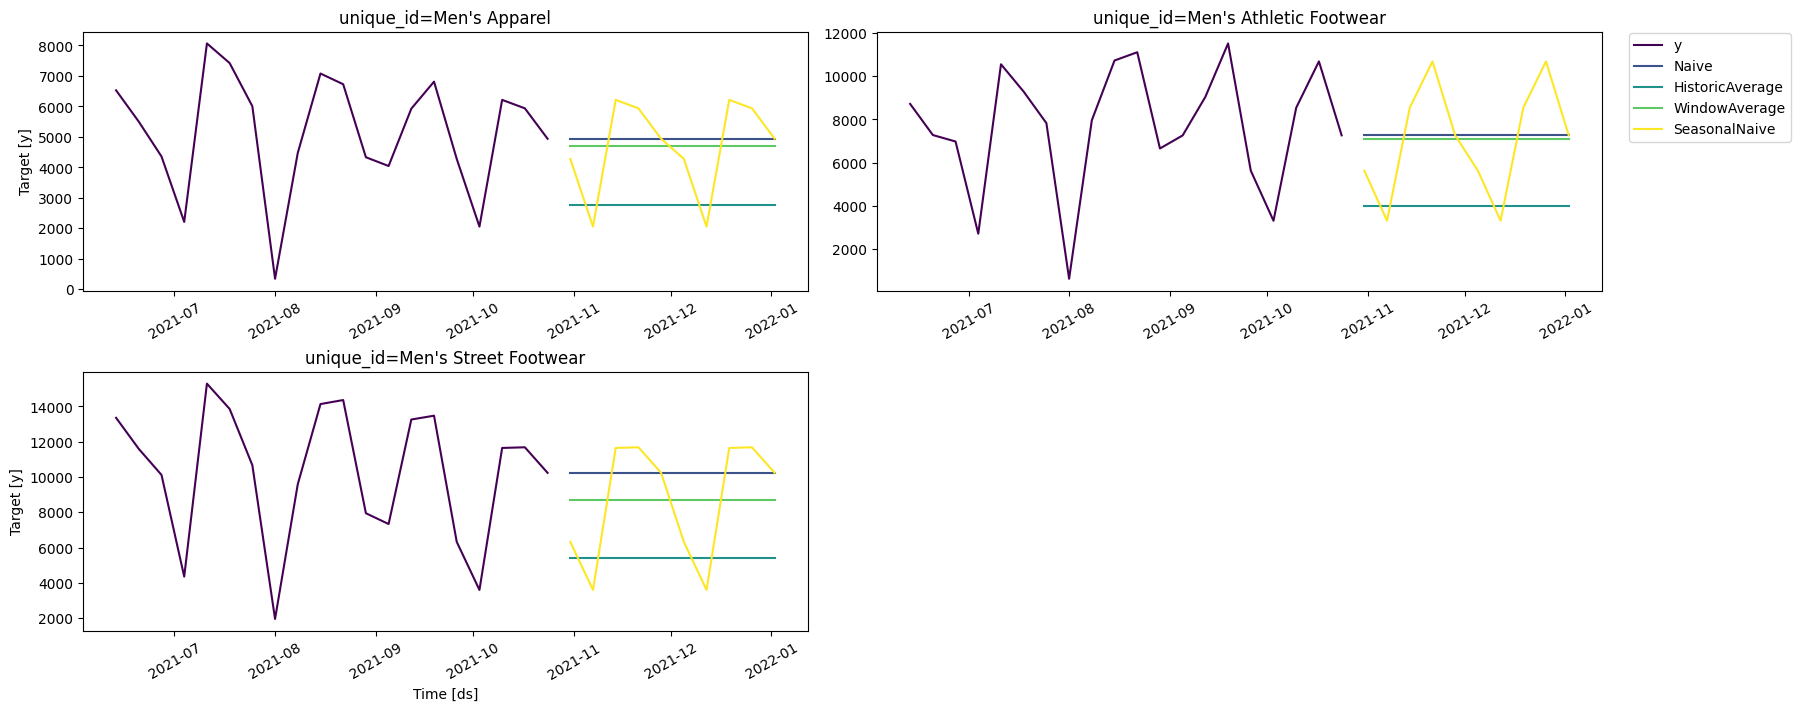

In [ ]:
plot_series(
    df = train,
    forecasts_df = predicts,
    max_insample_length= 20,
    palette="viridis"
)

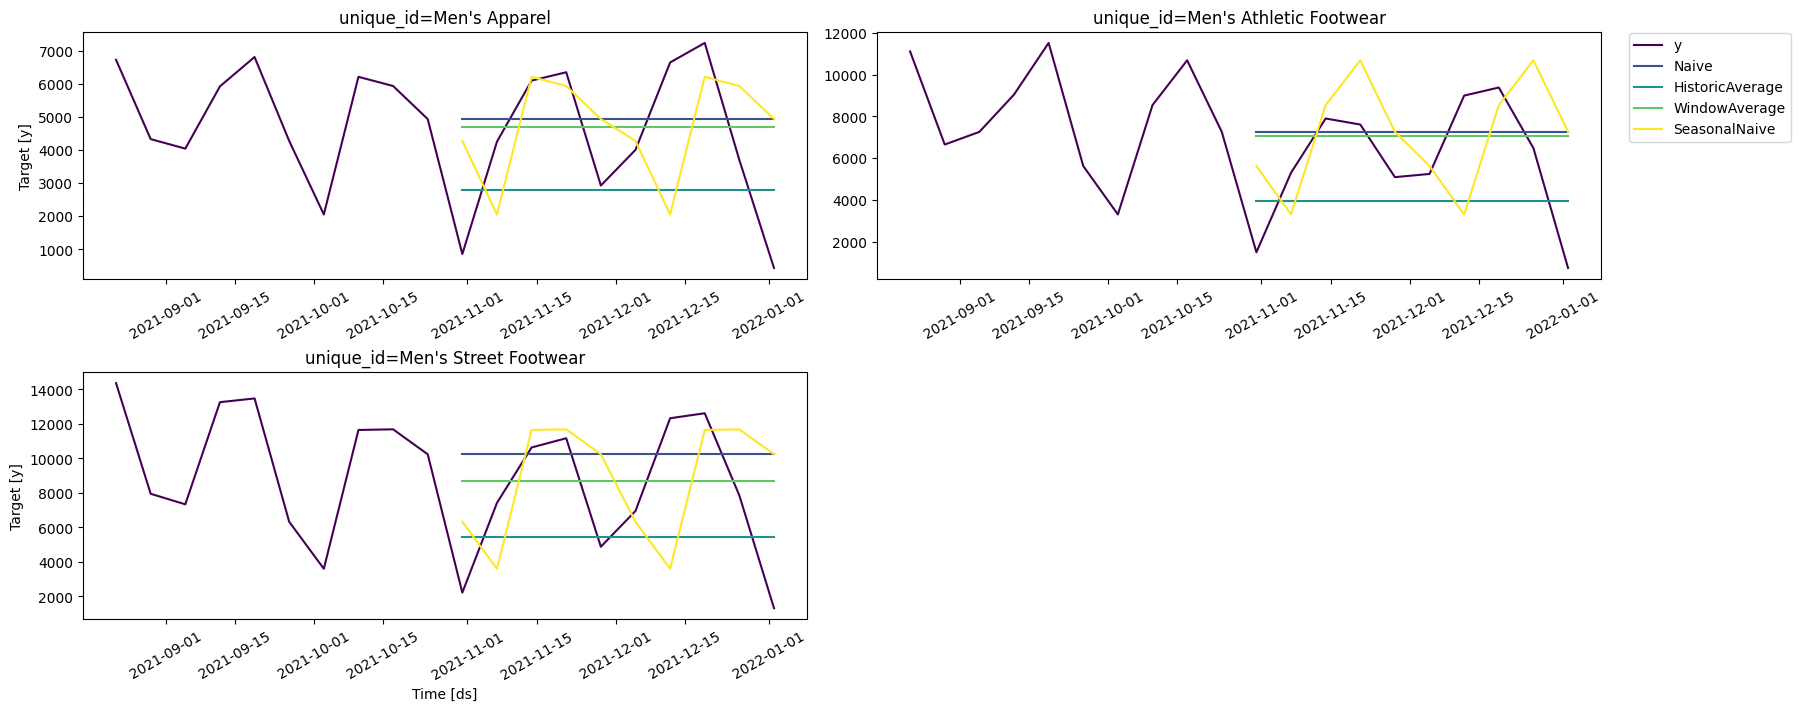

In [ ]:


plot_df = pd.concat([train, test])

plot_series(
    df=plot_df,          # train + test
    forecasts_df=predicts,
    max_insample_length=20,
    palette="viridis"
)


In [ ]:
eval_df = pd.merge(test,predicts,'left',on=['unique_id','ds'])
evaluation = evaluate(eval_df,metrics=[mae])
evaluation=evaluation.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
evaluation.head()



,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,2687.9,3066.44388,2556.540007,2942.833333


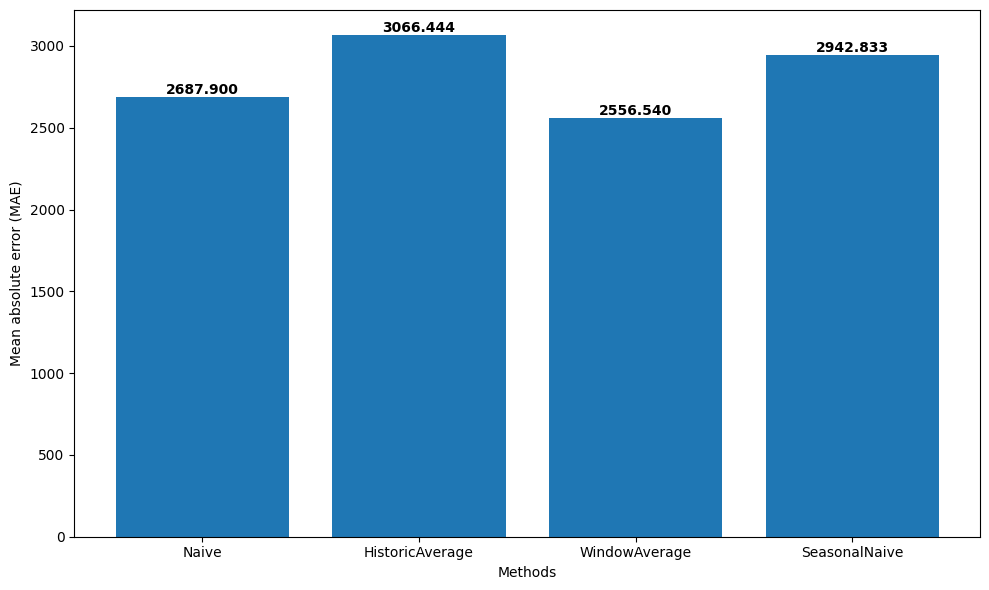

In [ ]:
methods = evaluation.columns[1:].tolist()
values = evaluation.iloc[0, 1:].tolist()

plt.figure(figsize=(10, 6))
bars = plt.bar(methods, values)

for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()

plt.show()


In [ ]:
mens_sales.shape
test.shape
train.shape


(285, 3)

In [ ]:
from statsforecast.models import AutoARIMA

arima_train = train.copy()
arima_test = test.copy()


models = [
    AutoARIMA(seasonal=False, alias="ARIMA"),
    AutoARIMA(seasonal=True, season_length=3, alias="SARIMA")
]

sf = StatsForecast(models=models, freq="W")
sf.fit(df=train)

horizon = len(test["ds"].unique())
arima_preds = sf.predict(h=horizon)


arima_eval_df = pd.merge(arima_preds,eval_df, on=["ds", "unique_id"], how="inner")


arima_eval = evaluate(arima_eval_df, metrics=[mae])
#arima_eval=arima_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
arima_eval


,unique_id,metric,ARIMA,SARIMA,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,Men's Apparel,mae,1224.542139,1360.812451,2001.5,2323.495850,1950.779980,2076.9
1,Men's Athletic Footwear,mae,1324.911328,1260.845044,2402.9,2992.510596,2367.300000,2961.1
2,Men's Street Footwear,mae,1476.950781,1444.785645,3659.3,3883.325195,3351.540039,3790.5


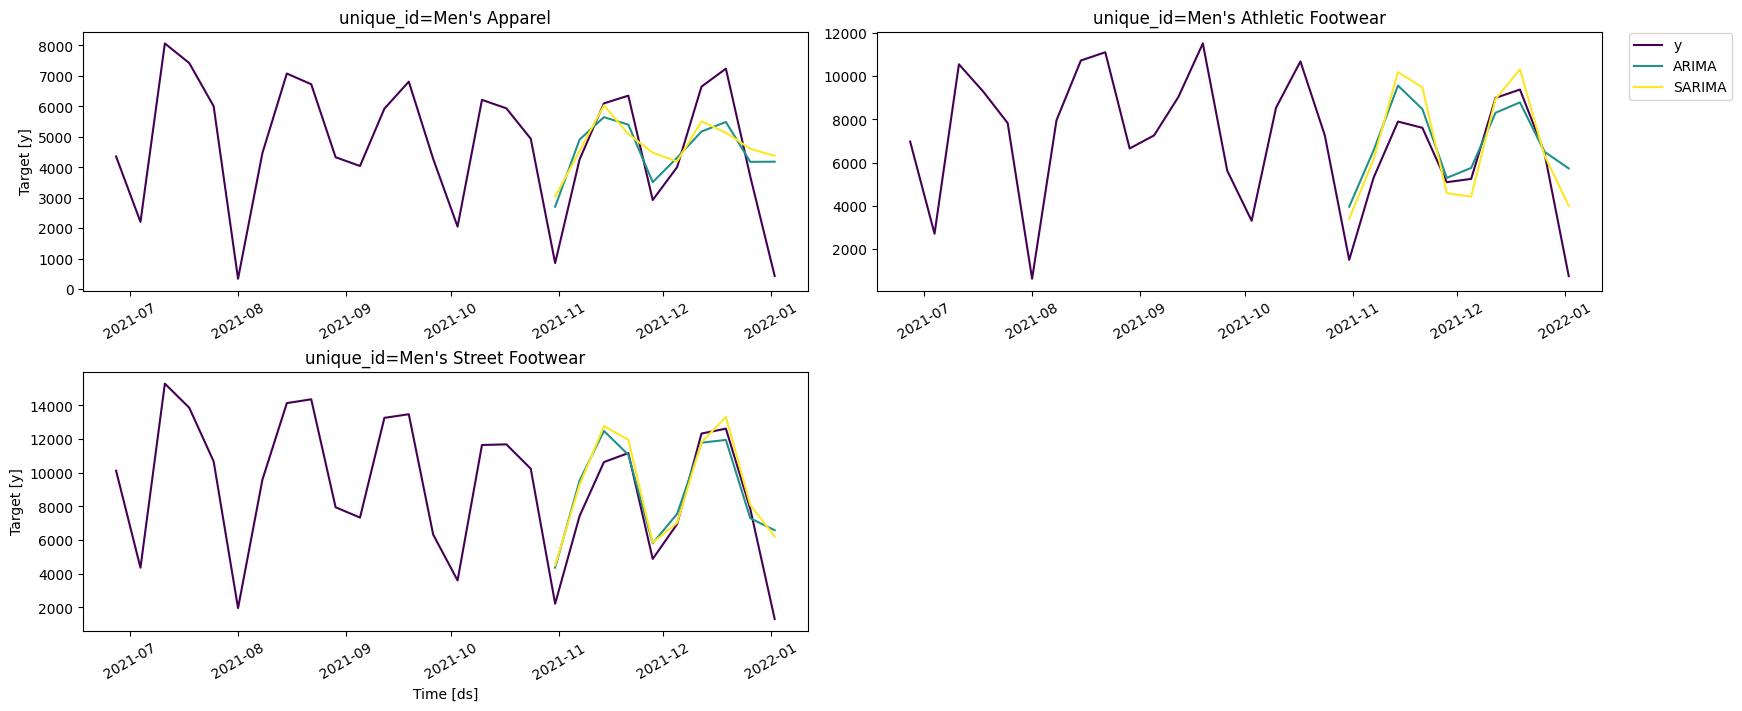

In [ ]:
plot_series(
    df=mens_sales,
    forecasts_df=arima_preds,
    max_insample_length=28,
    palette="viridis")

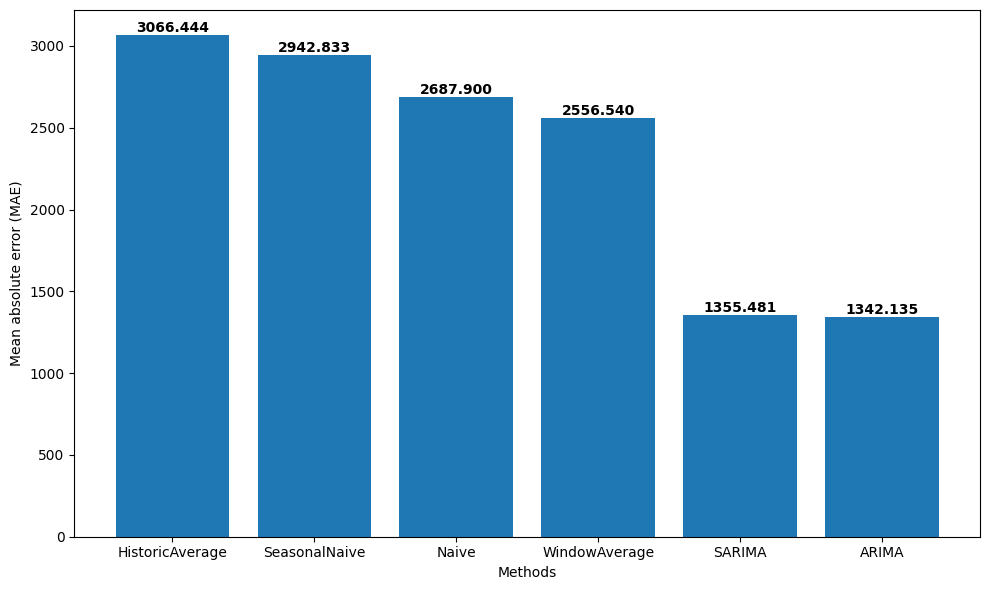

In [ ]:
methods = arima_eval.columns[1:].tolist()
values = arima_eval.iloc[0, 1:].tolist()

sorted_data = sorted(zip(methods, values), key=lambda x: x[1], reverse=True)
methods_sorted, values_sorted = zip(*sorted_data)

plt.figure(figsize=(10, 6))
bars = plt.bar(methods_sorted, values_sorted)

for bar, value in zip(bars, values_sorted):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()

plt.show()